#### Step 2

Download daily price data to plot estimators for mean and realized variance.

In [ ]:
import datetime as dt
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
# Why use Stooq?

today = pd.to_datetime("2025-03-05")
data = yf.download("AAPL", start="2010-01-01", end=today)

[*********************100%***********************]  1 of 1 completed


In [21]:
data.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 3773 entries, 2010-01-04 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3773 non-null   float64
 1   (High, AAPL)    3773 non-null   float64
 2   (Low, AAPL)     3773 non-null   float64
 3   (Open, AAPL)    3773 non-null   float64
 4   (Volume, AAPL)  3773 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 176.9 KB


In [22]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.418382,6.433077,6.369496,6.400987,493729600
2010-01-05,6.429480,6.465769,6.395590,6.436078,601904800
2010-01-06,6.327210,6.454972,6.320612,6.429480,552160000
2010-01-07,6.315514,6.358102,6.269628,6.350604,477131200
2010-01-08,6.357499,6.358099,6.269926,6.307114,447610800


#### Step 3: Historical Estimators

Compute the classical historical mean and volatility estimators.

In [25]:
# Estimating the drift parameter

# Assuming uniform increments DeltaT = 1 / 252 years

prices = data['Close'].squeeze()

# Computing simple returns
returns = prices.pct_change().dropna()

# Drift the estimator
td = 252
mu_ht = returns.mean() * td
print("Drift parameter estimate:\n ",mu_ht)

Drift parameter estimate:
  0.2839110549991427


In [27]:
# Volatility estimator

N = len(returns)
delta_t = 1/252 # daily time increment in yrs
T = N * delta_t # total time span in years

# Annualized drift estimator
mu_ht = returns.mean() / delta_t

# Volatility Estimator

# Term 1: (1/(N-1)) * sum( (1/delta_t) * returns^2 )
term1 = (1 / (N - 1)) * (1 / delta_t) * (returns ** 2).sum()

# Term 2: (T / (N-1)) * mu_hat^2
term2 = (T / (N - 1)) * (mu_ht ** 2)

# Realized volatility
sigma_ht = np.sqrt(term1 - term2)

print(f"Sample size (N): {N}")
print(f"Time span (T): {T:.2f} years")
print(f"Annualized drift: {mu_ht:.4f} ({mu_ht*100:.2f}%)")
print(f"Annualized volatility: {sigma_ht:.4f} ({sigma_ht*100:.2f}%)")

Sample size (N): 3772
Time span (T): 14.97 years
Annualized drift: 0.2839 (28.39%)
Annualized volatility: 0.2787 (27.87%)


Implement one alternative volatility estimator of your choice (e.g. Parkinson or GK) and compare it with the classical volatility estimator.

In [28]:
# GK Estimator for comparison

high = data["High"].squeeze()
low = data["Low"].squeeze()
close = data["Close"].squeeze()
open_ = data["Open"].squeeze()

T = len(close) # number of days

# GK Estimator (eq. 3)

# Term 1: (1/2T) * sum( [ln(h/l)]^2 )
term1 = (1 / (2 * T)) * (np.log(high / low) ** 2).sum()
# Term 2: (2*ln(2) - 1) / T * sum( [ln(c/o)]^2 )
term2 = ((2 * np.log(2) - 1) / T) * (np.log(close / open_) ** 2).sum()

# Daily variance and volatility
sigma_gk_daily = np.sqrt(term1 - term2)

# Annualize

# Annualize (multiply by sqrt(252))
sigma_gk_annualized = sigma_gk_daily * np.sqrt(252)

print(f"Garman-Klass volatility (daily): {sigma_gk_daily:.6f}")
print(f"Garman-Klass volatility (annualized): {sigma_gk_annualized:.4f} ({sigma_gk_annualized*100:.2f}%)")


Garman-Klass volatility (daily): 0.014010
Garman-Klass volatility (annualized): 0.2224 (22.24%)


Compute a rolling window estimator using a 30-day window. Plot the results for all estimators and explain your findings.

In [29]:
# Rolling window estimator.

window = 30 # 30-day window

# Standard estimator
rolling_classical = returns.rolling(window = window).std() * np.sqrt(252)

# Rolling GK Volatility

# Daily GK variance componenets
log_hl_sq = np.log(high / low) ** 2
log_co_sq = np.log(close / open_) ** 2

def gk_rolling(window):
    """Compute rolling GK volatility"""
    n = window
    term1 = (1 / (2 * n)) * log_hl_sq.rolling(window=n).sum()
    term2 = ((2 * np.log(2) - 1) / n) * log_co_sq.rolling(window=n).sum()
    daily_var = term1 - term2
    
    # Annualize
    return np.sqrt(daily_var.clip(lower = 0)) * np.sqrt(252)


rolling_gk = gk_rolling(window)

# Rolling drift

r_mu = returns.rolling(window = window).mean() * 252

In [33]:
print(f"\nRolling {window}-Day Estimator Statistics:")
print("="*50)
print(f"Classical Vol  - Mean: {rolling_classical.mean():.4f}, Std: {rolling_classical.std():.4f}")
print(f"Garman-Klass   - Mean: {rolling_gk.mean():.4f}, Std: {rolling_gk.std():.4f}")
print(f"Drift          - Mean: {r_mu.mean():.4f}, Std: {r_mu.std():.4f}")


Rolling 30-Day Estimator Statistics:
Classical Vol  - Mean: 0.2594, Std: 0.1030
Garman-Klass   - Mean: 0.2092, Std: 0.0754
Drift          - Mean: 0.2867, Std: 0.7774


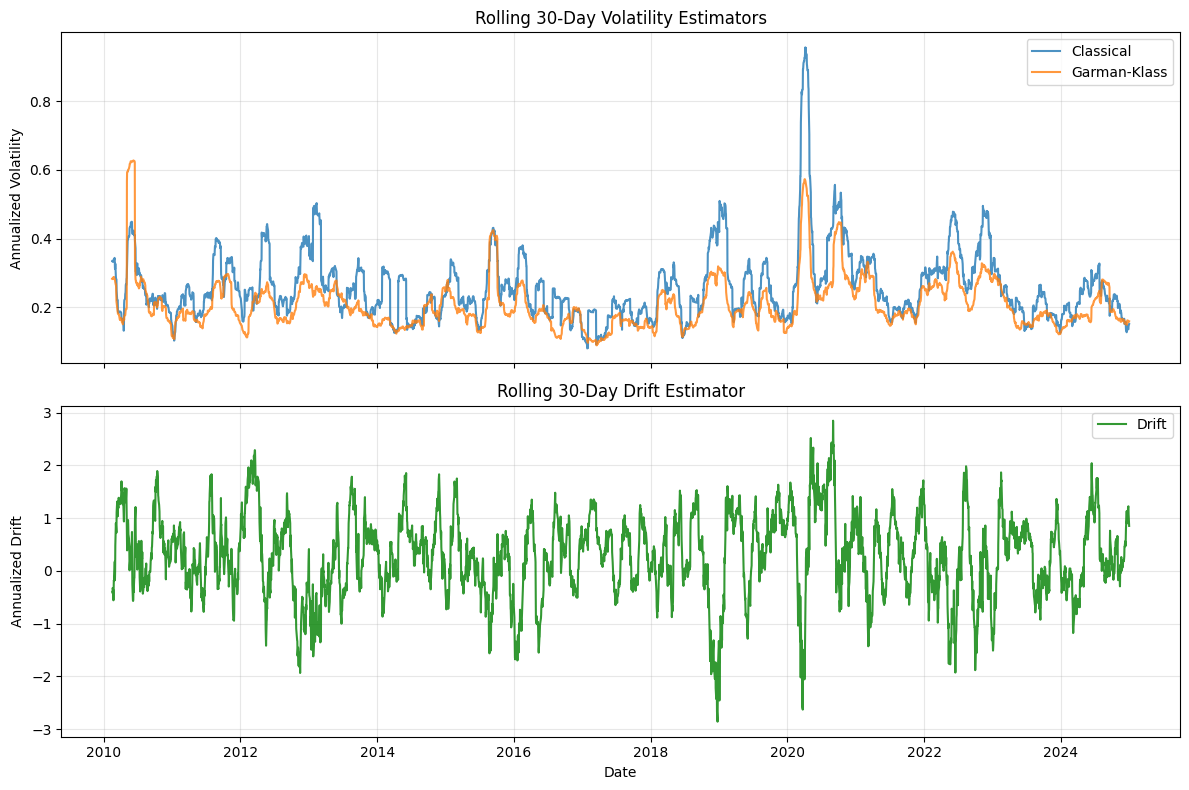

In [32]:
# Plotting

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Volatility estimators
axes[0].plot(rolling_classical.index, rolling_classical, label='Classical', alpha=0.8)
axes[0].plot(rolling_gk.index, rolling_gk, label='Garman-Klass', alpha=0.8)
axes[0].set_ylabel('Annualized Volatility')
axes[0].set_title(f'Rolling {window}-Day Volatility Estimators')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Drift estimator
axes[1].plot(r_mu.index, r_mu, label='Drift', color='green', alpha=0.8)
axes[1].set_ylabel('Annualized Drift')
axes[1].set_xlabel('Date')
axes[1].set_title(f'Rolling {window}-Day Drift Estimator')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Select one of the S&P500 stocks and comapare to the realized variance estimators with the time series of implied volatilities for a ticker. To retrieve implied volatility data, you can use the skfolio package.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset

# Load data
prices = load_sp500_dataset()
implied_vol = load_sp500_implied_vol_dataset()
ticker = "AAPL"

# Filter from 2010
prices_ticker = prices.loc["2010":, ticker]
implied_vol_ticker = implied_vol.loc["2010":, ticker]

# Compute returns and realized vol
returns = prices_ticker.pct_change().dropna()
realized_vol = returns.rolling(window=30).std() * np.sqrt(252)

realized_vol = realized_vol.dropna()
implied_vol_ticker = implied_vol_ticker.dropna()

# Find common dates
common_idx = realized_vol.index.intersection(implied_vol_ticker.index)
realized_vol_aligned = realized_vol.loc[common_idx]
implied_vol_aligned = implied_vol_ticker.loc[common_idx]

# Stats
print(f"\nRealized Vol - Mean: {realized_vol_aligned.mean():.4f}, Range: [{realized_vol_aligned.min():.4f}, {realized_vol_aligned.max():.4f}]")
print(f"Implied Vol  - Mean: {implied_vol_aligned.mean():.4f}, Range: [{implied_vol_aligned.min():.4f}, {implied_vol_aligned.max():.4f}]")
print(f"Correlation: {realized_vol_aligned.corr(implied_vol_aligned):.4f}")


Realized Vol - Mean: 0.2662, Range: [0.0807, 0.9560]
Implied Vol  - Mean: 0.2863, Range: [0.1663, 0.7279]
Correlation: 0.6769


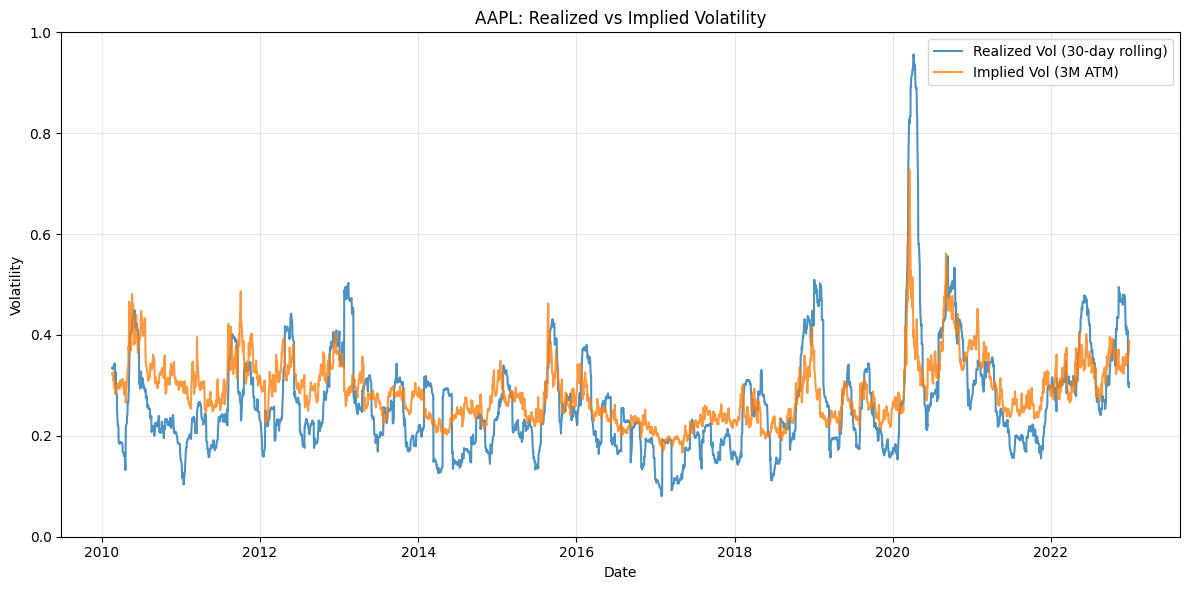

In [15]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(realized_vol_aligned.index, realized_vol_aligned, label='Realized Vol (30-day rolling)', alpha=0.8)
ax.plot(implied_vol_aligned.index, implied_vol_aligned, label='Implied Vol (3M ATM)', alpha=0.8)
ax.set_ylabel('Volatility')
ax.set_xlabel('Date')
ax.set_title(f'{ticker}: Realized vs Implied Volatility')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1) 
plt.tight_layout()
plt.show()

### Step 4: Implied Volatility Data and VIX Estimation

Download the SPX and VIX quoted data for the specified time window

In [17]:
# Fetch SPX data

today = pd.to_datetime("2025-03-05") # Keep this fixed
end_date = today
start_date = end_date - dt.timedelta(days = 365)

spx_data = yf.download("^GSPC", start=start_date, end = end_date)
spx_data = spx_data["Close"].squeeze().dropna()

if spx_data.empty:
    raise ValueError("No SPX data found")

lastBusDay = spx_data.index[-1]
S0 = float(spx_data.iloc[-1]) # closing price

[*********************100%***********************]  1 of 1 completed


In [18]:
# Fetch VIX data
from math import exp

vix_data = yf.download("^VIX", start= lastBusDay, 
                       end = lastBusDay + dt.timedelta(days = 30))
vix_data = vix_data["Close"].squeeze().dropna()

if vix_data.empty:
    raise ValueError("No VIX data found")

vix_market = float(vix_data.iloc[0])

# Fixed inputs
T = 30 / 365.0
r = 0.02
F0 = S0 * exp(r * T) # forward approx

print("Last Bus Day:", lastBusDay)
print("S0:", S0)
print("VIX market close:", vix_market)
print("F0:", F0)

[*********************100%***********************]  1 of 1 completed

Last Bus Day: 2025-03-04 00:00:00
S0: 5778.14990234375
VIX market close: 23.510000228881836
F0: 5787.656042075254


Compute the estimated VIX using the estimator $VIX_t$ (eq. 18) and compare it with the CBOE-quoted VIX.

Plot the historical estimated realized variances from Step 3 alongside the VIX time series. Perform statistical analyses(such as correlation or cointegration tests) to assess the relationship between the time series.

Run regression analyses between SPX returns and the VIX index, as well as between SPX returns and the historical realized variance estimator. Discuss your observations.

*Hint*: The variations of the stock index are typically negatively correlated with variations of the VIX index, whereas the correlation with historical volatility variations may differ.